[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/12_monsters_and_mixtures.ipynb)

# 12. Monsters and Mixtures

In [3]:
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from collections import namedtuple
import statsmodels.formula.api as smf

import random
import jax
import jax.numpy as jnp

import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
# to use 'sample_distributions'
import tensorflow_probability as xtfp
xtfd = xtfp.distributions
xtfb = xtfp.bijectors

key = tfp.util.SeedStream(1448, salt="ch-12")
plt.rcParams['figure.figsize'] = [6, 5]

# TFP often requires 64-bit precision (float64) for certain computations 
# to ensure numerical stability and accuracy, e.g., tfd.Possion.
jax.config.update("jax_enable_x64", True)

## 12.1 Over-dispersed counts

### 12.1.1 Beta-binomial

##### Code 12.1


A beta distribution is a probability distribution for probabilities !

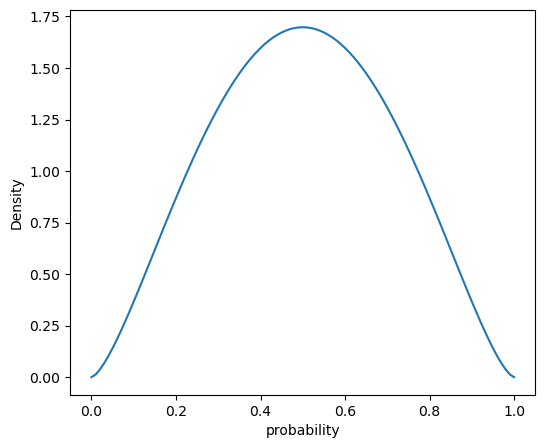

In [4]:
pbar = 0.5  # mean
theta = 5  # total concentration

alpha = pbar * theta
beta = (1 - pbar) * theta

x = np.linspace(0, 1, 101)

plt.plot(x, tfd.Beta(alpha, beta).prob(x))
plt.xlabel("probability")
plt.ylabel("Density")
plt.show()

##### Code 12.2

In [2]:
d = pd.read_csv("./data/UCBadmit.csv", sep=";")
d["gid"] = (d["applicant.gender"] != "male").astype(int)

In [6]:
d

,dept,applicant.gender,admit,reject,applications,gid
1,A,male,512,313,825,0
2,A,female,89,19,108,1
3,B,male,353,207,560,0
4,B,female,17,8,25,1
5,C,male,120,205,325,0
6,C,female,202,391,593,1
7,D,male,138,279,417,0
8,D,female,131,244,375,1
9,E,male,53,138,191,0
10,E,female,94,299,393,1


In [5]:
def model_12_1(gid, N):
	def _generator():
		a = yield tfd.Sample(tfd.Normal(loc=0.0, scale=1.5), sample_shape=2, name='a')
		phi = yield tfd.Exponential(rate=1.0, name='phi')
		theta = phi + 2
		pbar = jax.nn.sigmoid(jnp.take(a, gid))

		concentration1 = pbar * theta
		concentration0 = (1 - pbar) * theta

		yield tfd.BetaBinomial(
			total_count=N, 
			concentration1=concentration1, concentration0=concentration0,
			name='A')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [12]:
jd_12_1 = model_12_1(d.gid.values, d.applications.values.astype(np.float32))

In [13]:
jd_12_1_pin = jd_12_1.experimental_pin(A=d.admit.values)

In [14]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=400):

  def target_log_prob(*states):
    return jd_12_1_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Exp()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [15]:
num_chains = 4
init_state = jd_12_1_pin.sample_unpinned(num_chains, seed=key())
post_1 = run_chain(init_state=init_state, seed=key())

In [16]:
post_1_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_1._asdict().items()}
dict_1 = dict(posterior=post_1_dict)
idata_1 = az.from_dict(**dict_1)

In [17]:
az.summary(idata_1, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.449,0.395,-1.074,0.163,0.009,0.008,2108.0,1157.0,1.00
a[1],-0.322,0.402,-0.933,0.310,0.008,0.008,2789.0,1443.0,1.00
phi,1.021,0.755,0.001,2.008,0.029,0.021,503.0,373.0,1.01


##### Code 12.3

In [18]:
# compute the difference between alphas
idata_1.posterior["da"] = idata_1.posterior["a"][:, :, 0] - idata_1.posterior["a"][:, :, 1]

# compute theta
idata_1.posterior["theta"] = idata_1.posterior["phi"] + 2

In [19]:
az.summary(idata_1, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.449,0.395,-1.074,0.163,0.009,0.008,2108.0,1157.0,1.00
a[1],-0.322,0.402,-0.933,0.310,0.008,0.008,2789.0,1443.0,1.00
phi,1.021,0.755,0.001,2.008,0.029,0.021,503.0,373.0,1.01
da,-0.127,0.555,-0.922,0.805,0.011,0.013,2681.0,1183.0,1.00
theta,3.021,0.755,2.001,4.008,0.029,0.021,503.0,373.0,1.01


##### Code 12.4

In [40]:
theta = post_1_dict['phi'][0, :] + 2
theta[2]

Array(2.0049706, dtype=float32)

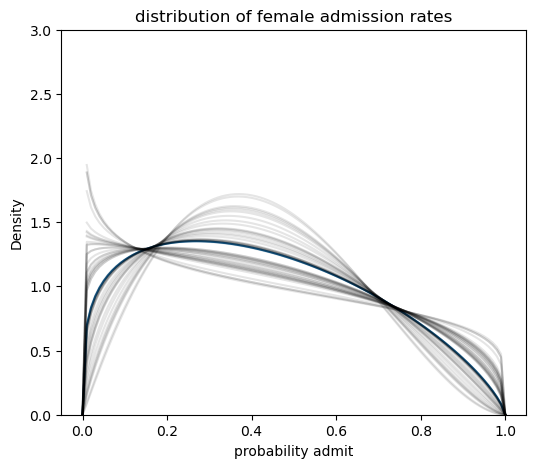

In [52]:
a = post_1_dict['a'][0, :, 1] # female
theta = post_1_dict['phi'][0, :] + 2

# draw posterior mean beta distribution
x = np.linspace(0, 1, 101)
pbar = jnp.mean(jax.nn.sigmoid(a))
thetabar = jnp.mean(theta)
plt.plot(x, tfd.Beta(pbar * thetabar, (1 - pbar) * thetabar).prob(x))
plt.gca().set(ylabel="Density", xlabel="probability admit", ylim=(0, 3))

# draw 50 beta distributions sampled from posterior
for i in np.random.choice(500, 50):
	p = jax.nn.sigmoid(a[i])
	thetai = theta[i]
	plt.plot(x, tfd.Beta(pbar * thetai, (1 - pbar) * thetai).prob(x), "k", alpha=0.1)
plt.title("distribution of female admission rates")
plt.show()

##### Code 12.5

In [63]:
# get samples given the posterior distribution
N = d.applications.values.astype(np.float32)
gid = d.gid.values

# prepare the concentration vector
concentration1 = pbar * thetabar
concentration0 = (1 - pbar) * thetabar

dist = tfd.BetaBinomial(
  total_count=N, 
  concentration1=concentration1, concentration0=concentration0)

predictive_samples = dist.sample(500, seed=key())
admit_rate = predictive_samples / N

In [64]:
admit_rate.shape

(500, 12)

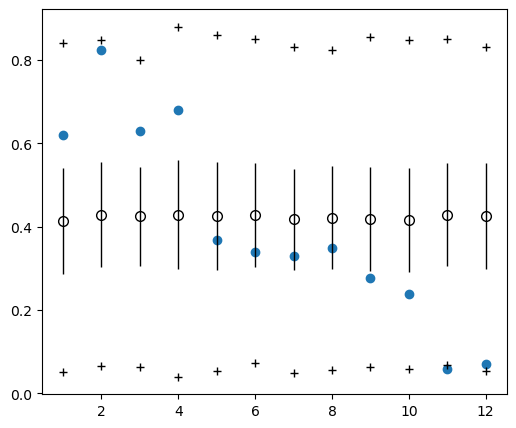

In [65]:
plt.scatter(range(1, 13), d.admit.values / N)
plt.errorbar(
    range(1, 13),
    np.mean(admit_rate, 0),
    np.std(admit_rate, 0) / 2,
    fmt="o",
    c="k",
    mfc="none",
    ms=7,
    elinewidth=1,
)
plt.plot(range(1, 13), np.percentile(admit_rate, 5.5, 0), "k+")
plt.plot(range(1, 13), np.percentile(admit_rate, 94.5, 0), "k+")
plt.show()

In the above plot, the vertifical axis shows the predicted proportion admitted, for each case on the horizontal.

Blue points show the empirical proportion admitted on each row of data

Open circles are the posterior mean pbar and + symbols mark the 89% interval of predicted counts of admission

### 12.1.2 Negative-binomial or gamma-Poisson

##### Code 12.6 

Start to use **Gamma-Poisson** (also known as **Negative Binomial**) models.

Essentially Gamm-Poisson is about associating a rate to each Posisson count observation. Estimates the shape of gamma distribution to describe the Poisson rates across cases.

Gamma-Poisson also expects more variation around the mean rate.

The negative binomial distribution arises naturally from a probability experiment of performing a series of independent Bernoulli trials until the occurrence of the rth success where r is a positive integer.

In [69]:
d = pd.read_csv("./data/Kline.csv", sep=";")
d["P"] = d.population.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())
d["contact_id"] = (d.contact == "high").astype(int)
d

,culture,population,contact,total_tools,mean_TU,P,contact_id
0,Malekula,1100,low,13,3.2,-1.291473,0
1,Tikopia,1500,low,22,4.7,-1.088551,0
2,Santa Cruz,3600,low,24,4.0,-0.515765,0
3,Yap,4791,high,43,5.0,-0.328773,1
4,Lau Fiji,7400,high,33,5.0,-0.044339,1
5,Trobriand,8000,high,19,4.0,0.006668,1
6,Chuuk,9200,high,40,3.8,0.098109,1
7,Manus,13000,low,28,6.6,0.324318,0
8,Tonga,17500,high,55,5.4,0.518798,1
9,Hawaii,275000,low,71,6.6,2.321008,0


In [101]:
# dgampois( x , mu , scale , log=FALSE )

# == dnbinom(x, size=mu/scale, prob=1/(1+scale), mu=mu, log = FALSE)
#    - x: number of failures
#    - size: number of successes
#    - prob: probability of success,  size / (size + mu)
#    - mu: size * (1 - prob) / prob

# == tfd.NegativeBinomial(total_count=size, probs=1-prob)
# NOTE: In the official document says, 
#        total_count=x, probs=prob.
#       But dnbinom outputs match with:
#        total_count=size, probs=1-prob

tfd.NegativeBinomial(total_count=1., probs=.3).prob([1., 2., 3.])
# == dnbinom(c(1, 2, 3), size=1, prob=.7)

Array([0.20999995, 0.06300002, 0.0189    ], dtype=float32)

In [125]:
def model_12_2(cid, P):
	def _generator():
		# g = yield tfd.Exponential(rate=1.0, name='g')
		phi = yield tfd.Exponential(rate=1.0, name='phi')
		# a = yield tfd.Normal(loc=1.0, scale=1.0, name='a')
		# b = yield tfd.Exponential(rate=1.0, name='b')
		# NOTE: the scientific approach does not work
		# mu = jnp.exp(jnp.take(a, cid)) * jnp.pow(P, jnp.take(b, cid)) / g
		lambda_ = yield tfd.Exponential(rate=1.0, name='lambda_')
		yield tfd.Sample(
			tfd.NegativeBinomial(total_count=lambda_/phi, probs=phi/(1+phi)),
			sample_shape=10, name='tools')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [126]:
jd_12_2 = model_12_2(d.contact_id.values, d.P.values.astype(np.float32))

In [127]:
jd_12_2_pin = jd_12_2.experimental_pin(tools=d.total_tools.values.astype(np.float32))

In [128]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=400):

  def target_log_prob(*states):
    return jd_12_2_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Exp(), tfb.Exp()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [129]:
num_chains = 4
init_state = jd_12_2_pin.sample_unpinned(num_chains, seed=key())
post_2 = run_chain(init_state=init_state, seed=key())

In [130]:
post_2_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_2._asdict().items()}
dict_2 = dict(posterior=post_2_dict)
idata_2 = az.from_dict(**dict_2)

In [131]:
az.summary(idata_2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_,19.731,3.804,13.814,25.545,0.121,0.086,989.0,1104.0,1.0
phi,5.696,1.961,2.708,8.473,0.075,0.053,645.0,580.0,1.0


## 12.2 Zero-inflated outcomes

##### Code 12.6 

In [150]:
# define parameters
prob_drink = 0.2 # 20% of days
rate_work = 1 # average 1 manuscript per day
# sample one year of production
N = 365
# simulate days monks drink
drink = tfd.Bernoulli(probs=prob_drink).sample(N, seed=key())
# simulate manuscripts completed
y = (1 - drink) * tfd.Poisson(rate=rate_work).sample(N, seed=key())

In [151]:
zeros_drink = jnp.sum(drink)
zeros_work = jnp.sum((y==0) & (drink==0))
zeros_total = jnp.sum(y==0)

zeros_drink, zeros_work, zeros_total

(Array(65, dtype=int64), Array(110, dtype=int64), Array(175, dtype=int64))

##### Code 12.9

In [169]:
def model_12_3():
	def _generator():
		al = yield tfd.Normal(loc=1.0, scale=0.5, name='al')
		ap = yield tfd.Normal(loc=-1.5, scale=1.0, name='ap')
		yield tfd.Sample(
			tfd.Inflated(tfd.Poisson(log_rate=al), inflated_loc_logits=ap), 
			sample_shape=365, name='y')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [170]:
jd_12_3 = model_12_3()

In [171]:
jd_12_3_pin = jd_12_3.experimental_pin(y=y)

In [176]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=500):

  def target_log_prob(*states):
    return jd_12_3_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [177]:
num_chains = 4
init_state = jd_12_3_pin.sample_unpinned(num_chains, seed=key())
post_3 = run_chain(init_state=init_state, seed=key())

In [178]:
post_3_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_3._asdict().items()}
dict_3 = dict(posterior=post_3_dict)
idata_3 = az.from_dict(**dict_3)

In [179]:
az.summary(idata_3, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
al,-0.085,0.093,-0.239,0.048,0.005,0.003,400.0,746.0,1.01
ap,-1.171,0.541,-1.839,-0.521,0.036,0.026,267.0,308.0,1.02


##### Code 12.10

In [182]:
(
  jnp.mean(jax.nn.sigmoid(post_3_dict['ap'])), # probability drink
  jnp.mean(jnp.exp(post_3_dict['al'])) # rate finish manuscripts, when not drinking
)

(Array(0.24943775, dtype=float32), Array(0.9228564, dtype=float32))

## 12.3 Ordered categorical outcomes

##### Code 12.12

In [4]:
d = pd.read_csv("./data/Trolley.csv", sep=";")
d['response'] = d['response'] - 1
d

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,3,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,2,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,3,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,2,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,2,4,96;434,14,0,Middle School,0,1,1,bur,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9925,ilpon,2,23,98;299,66,1,Graduate Degree,0,1,0,pon,0
9926,ilsha,5,15,98;299,66,1,Graduate Degree,0,1,0,sha,0
9927,ilshi,6,7,98;299,66,1,Graduate Degree,0,1,0,shi,0
9928,ilswi,1,18,98;299,66,1,Graduate Degree,0,1,0,swi,0


In [24]:
def model_12_4():
	def _generator():
		cutpoints = yield tfd.TransformedDistribution(
			distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=6), 
			bijector=tfb.Ascending(), name='cutpoints')
		yield tfd.Sample(
			tfd.OrderedLogistic(cutpoints=cutpoints, loc=0.), 
			sample_shape=9930, name='response')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [25]:
jd_12_4 = model_12_4()

In [26]:
jd_12_4_pin = jd_12_4.experimental_pin(response=d.response.values.astype(np.float32))

In [28]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=500):

  def target_log_prob(*states):
    return jd_12_4_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [29]:
num_chains = 4
init_state = jd_12_4_pin.sample_unpinned(num_chains, seed=key())
post_4 = run_chain(init_state=init_state, seed=key())

In [30]:
post_4_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_4._asdict().items()}
dict_4 = dict(posterior=post_4_dict)
idata_4 = az.from_dict(**dict_4)

In [32]:
summary_4 = az.summary(idata_4, hdi_prob=0.89)
summary_4

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],-1.915,0.029,-1.961,-1.869,0.001,0.001,1165.0,1285.0,1.0
cutpoints[1],-1.267,0.024,-1.306,-1.230,0.001,0.001,1074.0,1305.0,1.0
cutpoints[2],-0.719,0.021,-0.753,-0.685,0.001,0.000,1055.0,1208.0,1.0
cutpoints[3],0.248,0.021,0.216,0.282,0.001,0.000,1089.0,900.0,1.0
cutpoints[4],0.889,0.023,0.855,0.928,0.001,0.000,1074.0,1034.0,1.0
cutpoints[5],1.769,0.029,1.723,1.816,0.001,0.001,1131.0,1122.0,1.0


##### Code 12.19

In [36]:
summary_4['mean'].pipe(lambda x: 1 / (1 + np.exp(-x)))

cutpoints[0]    0.128420
cutpoints[1]    0.219771
cutpoints[2]    0.327613
cutpoints[3]    0.561684
cutpoints[4]    0.708684
cutpoints[5]    0.854333
Name: mean, dtype: float64

##### Code 12.20

In [47]:
coef_4 = summary_4['mean'].values
pk = tfd.OrderedLogistic(cutpoints=coef_4, loc=0.).prob(jnp.arange(7))
pk

Array([0.12842017, 0.09135107, 0.10784199, 0.23407094, 0.14699959,
       0.1456495 , 0.14566673], dtype=float64)

##### Code 12.21

In [46]:
jnp.sum(pk * (jnp.arange(7) + 1))

Array(4.19949416, dtype=float64)

##### Code 12.22

In [48]:
pk = tfd.OrderedLogistic(cutpoints=coef_4 - 0.5, loc=0.).prob(jnp.arange(7))
pk

Array([0.082036  , 0.06387981, 0.08219667, 0.20921881, 0.15871065,
       0.18452957, 0.21942848], dtype=float64)

##### Code 12.23

In [49]:
jnp.sum(pk * (jnp.arange(7) + 1))

Array(4.72999096, dtype=float64)

##### Code 12.24

WARNING: The following model_12_5 consumes almost all resources and tries running forever. I guess the input data might be treated as batch (probably at phi).
Numpyro version runs in 17.8s. 

In [5]:
def model_12_5(I):
	def _generator():
		bA = yield tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=1, name='bA')
		bI = yield tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=1, name='bI')
		# bC = yield tfd.Normal(loc=0., scale=0.5, name='bC')
		# bIA = yield tfd.Normal(loc=0., scale=0.5, name='bIA')
		# bIC = yield tfd.Normal(loc=0., scale=0.5, name='bIC')
		# BI = bI + bIA*A + bIC*C
		# phi = bA*A + bC*C + BI*I
		phi = bA + bI*I
		cutpoints = yield tfd.TransformedDistribution(
			distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=6), 
			bijector=tfb.Ascending(), name='cutpoints')	
		yield tfd.Sample(tfd.OrderedLogistic(cutpoints=cutpoints, loc=phi), 
									 sample_shape=9930, name='response')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [6]:
# jd_12_5 = model_12_5(A=d.action.values.astype(np.float32), 
#                      I=d.intention.values.astype(np.float32), 
#                      C=d.contact.values.astype(np.float32))
jd_12_5 = model_12_5(I=d.intention.values.astype(np.float32))

In [7]:
jd_12_5_pin = jd_12_5.experimental_pin(response=d.response.values.astype(np.float32))

In [8]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=5, burnin=2):

  def target_log_prob(*states):
    return jd_12_5_pin.unnormalized_log_prob(states)
  
  # bijectors = [tfb.Identity(), tfb.Identity(), tfb.Identity(),
  #              tfb.Identity(), tfb.Identity(), tfb.Identity()]
  bijectors = [tfb.Identity(), tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [9]:
num_chains = 1
init_state = jd_12_5_pin.sample_unpinned(num_chains, seed=key())
post_5 = run_chain(init_state=init_state, seed=key())

In [ ]:
# post_5_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_5._asdict().items()}
# dict_5 = dict(posterior=post_5_dict)
# idata_5 = az.from_dict(**dict_5)

In [ ]:
# summary_5 = az.summary(idata_5, hdi_prob=0.89)
# summary_5